In [37]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [38]:
def K_calc(X1,X2,sigma):
    sub=X1-X2
    norm=np.dot(np.transpose(sub),sub) # sum xi**2
    K=np.exp(-norm/(2*sigma**2))
    return K[0,0]
    
# Cross validation

def cross_validation(x_train,y_train,x_test,y_test,gamma_values,sigma_values,N_fold):

    fold_size= (x_train.shape[1])//N_fold
    
    least_val_MSE=-1   
    avg_val_MSE_plot=[]      
                    
    for gamma in gamma_values:
        
        
        avg_val_MSE_plot_help=[]
        
        for sigma in sigma_values:
       
            
            avg_val_MSE=0
            avg_train_MSE=0
            
            print('gamma id '+str(gamma_values.index(gamma))+', sigma id '+str(sigma_values.index(sigma)))
            
            for fold_id in range(N_fold): # work on first N fold
            
                # N folds
                x_val_cross = x_train[:,fold_id*fold_size:min((fold_id+1)*fold_size,x_train.shape[1])]
                x_train_cross = np.c_[x_train[:,0:fold_id*fold_size],x_train[:,(fold_id+1)*fold_size:x_train.shape[1]]]
                
                y_val_cross = y_train[:,fold_id*fold_size:min((fold_id+1)*fold_size,y_train.shape[1])]
                y_train_cross = np.c_[y_train[:,0:fold_id*fold_size],y_train[:,(fold_id+1)*fold_size:y_train.shape[1]]]            
        
                # Calculate K for this sigma and train folds
                l=x_train_cross.shape[1]
                K_train=np.zeros((l,l)) # K(xi,xj)
                
                
                for i in range(l):
                    for j in range(l):
                       xi=np.reshape(x_train_cross[:,i],(-1,1))
                       xj=np.reshape(x_train_cross[:,j],(-1,1))
                        
                       K_train[i,j]=K_calc(xi,xj,sigma) 
                       
                
                # Calculate K for this sigma and val fold, not square!
                l1=x_val_cross.shape[1]
                K_val=np.zeros((l,l1)) # K(xi,xj)
                
                for i in range(l):
                    for j in range(l1):
                        xi=np.reshape(x_train_cross[:,i],(-1,1))
                        xj=np.reshape(x_val_cross[:,j],(-1,1))  
                        
                        K_val[i,j]=K_calc(xi,xj,sigma)            
              
                    
                # TRAINING for train folds, get alpha* for this combination of gamma and sigma
                
                alpha=np.dot(np.linalg.inv(K_train+gamma*l*np.eye(l)),np.transpose(y_train_cross))
                    
                
                # VALIDATION on val fold for this combo, find MSE with Kval, and with Ktrain
                error=np.dot(np.transpose(alpha),K_val)-y_val_cross
                val_MSE=np.dot(error,np.transpose(error))/l1
                
               # print(val_MSE)
                
                error=np.dot(np.transpose(alpha),K_train)-y_train_cross
                train_MSE=np.dot(error,np.transpose(error))/l
                
               # print(val_MSE)
                
                # Average MSE val
                
                avg_val_MSE+= val_MSE
                avg_train_MSE+= train_MSE
               
                
                
            # Avg MSE and new best paramenters 
            
            avg_val_MSE = avg_val_MSE[0,0]
            avg_val_MSE /= N_fold
            avg_val_MSE_plot_help.append(avg_val_MSE)
            print('MSE = '+str(avg_val_MSE))      
            
            avg_train_MSE = avg_train_MSE[0,0]
            avg_train_MSE /= N_fold
            
            print('train MSE = '+str(avg_train_MSE))
    
           
            if least_val_MSE==-1 or least_val_MSE>avg_val_MSE:
               
                least_val_MSE=avg_val_MSE
                best_gamma=gamma
                best_sigma=sigma
    
        avg_val_MSE_plot.append(avg_val_MSE_plot_help) # add to a MSE val plot for all combo
        
    return best_gamma, best_sigma, avg_val_MSE_plot 
        
        

#  Retrain on whole train set for the best parameters

def MSE_train_test(x_train,x_test, y_train, y_test, best_gamma, best_sigma):
    
    # Calculate K for best param
    l3=x_train.shape[1]
    K_train=np.zeros((l3,l3))
    for i in range(l3):
        for j in range(l3):
            
            xi=np.reshape(x_train[:,i],(-1,1))
            xj=np.reshape(x_train[:,j],(-1,1))
            
            K_train[i,j] = K_calc(xi,xj,best_sigma)
            
    l4=x_test.shape[1]
    K_test=np.zeros((l3,l4))
    for i in range(l3):
        for j in range(l4):
            
            xi=np.reshape(x_train[:,i],(-1,1))
            xj=np.reshape(x_test[:,j],(-1,1))
            
            K_test[i,j]= K_calc(xi,xj,best_sigma)
            
    # Train
    
    alpha=np.dot(np.linalg.inv(K_train+best_gamma*l3*np.eye(l3)),np.transpose(y_train))
         
    # Calculate MSE train and test for best parameters
    
    error=np.dot(np.transpose(alpha),K_train)-y_train
    train_MSE=np.dot(error,np.transpose(error))/l3
    
    print('Train MSE = '+str(train_MSE[0,0]))
    
    error=np.dot(np.transpose(alpha),K_test)-y_test
    test_MSE=np.dot(error,np.transpose(error))/l4
    print('Test MSE = '+str(test_MSE[0,0]))
    
    return train_MSE[0,0], test_MSE[0,0]

In [39]:
dataset_file = 'C:/Users/aleks/Documents/UCL ML/Supervised/Assignment 1/BostonDataset.csv'

## load the dataset into a pandas dataframe
data_frame = pd.read_csv(dataset_file)

# convert dataframe to np array
data_array = data_frame.to_numpy()
print(data_array.shape)

# number of runs for each experiment (defined on the assignement paper)
N = 20
N_fold = 5
features_number = 13
test_split = round(((len(data_array)/3)/len(data_array)*100)/100,2)

train_data, test_data = train_test_split(data_array,test_size=test_split)


x_train = train_data[:,:features_number-1].T
x_test = test_data[:,:features_number-1].T


y_train = np.reshape(train_data[:,(features_number-1)],(1,x_train.shape[1]))
y_test = np.reshape(test_data[:,(features_number-1)],(1,x_test.shape[1]))


(506, 13)


In [40]:
# Define values for parameters
gamma_values=np.flip(np.power(0.5,np.array(range(26,41)))).tolist()
sigma_values=np.power(2,np.arange(7.0, 13.5, 0.5)).tolist()

In [41]:
# Cross validation

best_gamma, best_sigma, avg_val_MSE_plot = cross_validation(x_train,y_train,x_test,y_test,gamma_values,sigma_values,N_fold)

gamma id 0, sigma id 0
MSE = 793.1092167178649
train MSE = 0.4178613304238067
gamma id 0, sigma id 1
MSE = 238.68986542572748
train MSE = 0.8563347787204826
gamma id 0, sigma id 2
MSE = 137.34779088465646
train MSE = 1.5651825254602165
gamma id 0, sigma id 3
MSE = 67.64178038233518
train MSE = 2.2508852506403287
gamma id 0, sigma id 4
MSE = 30.84917426195246
train MSE = 2.9637880017604608
gamma id 0, sigma id 5
MSE = 18.48663374639245
train MSE = 4.158814987164918
gamma id 0, sigma id 6
MSE = 15.649791608787032
train MSE = 5.548890527819431
gamma id 0, sigma id 7
MSE = 13.397297609766872
train MSE = 6.573485647409439
gamma id 0, sigma id 8
MSE = 12.814610053338313
train MSE = 7.4881745453014705
gamma id 0, sigma id 9
MSE = 12.46259202131834
train MSE = 8.227672375039727
gamma id 0, sigma id 10
MSE = 12.337224450166074
train MSE = 9.04863691751233
gamma id 0, sigma id 11
MSE = 13.136407225442571
train MSE = 10.342185946454318
gamma id 0, sigma id 12
MSE = 15.336569239690487
train MSE = 

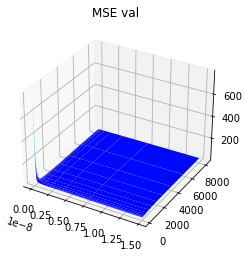

In [42]:
# Plot average MSE

Z=np.asarray(avg_val_MSE_plot)
X, Y = np.meshgrid(gamma_values, sigma_values)

fig = plt.figure()
ax = plt.axes(projection="3d")

ax.plot_surface(X, Y, Z.T, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title('MSE val')
plt.show()

In [43]:
# 
train_MSE, test_MSE = MSE_train_test(x_train,x_test,y_train,y_test,best_gamma, best_sigma)

Train MSE = 8.020136534647001
Test MSE = 10.60519913453388


In [45]:
# Retrain 20 times on the whole trainset for best param, for different train and test splits

MSEs_train=[]     
MSEs_test=[]

for i in range(N):
    print('Run '+str(i+1))
    
    # Spliting
    train_data, test_data = train_test_split(data_array,test_size=test_split)
    
    # Reshaping the data set
    x_train = train_data[:,:features_number-1].T
    x_test = test_data[:,:features_number-1].T
    y_train = np.reshape(train_data[:,(features_number-1)],(1,x_train.shape[1]))
    y_test = np.reshape(test_data[:,(features_number-1)],(1,x_test.shape[1]))
    
    # Training and testing
    trMSE, testMSE = MSE_train_test(x_train,x_test, y_train,y_test, best_gamma, best_sigma)
    
    MSEs_train.append(trMSE)
    MSEs_test.append(testMSE)
 
m_train = np.mean(MSEs_train)
s_train = np.std(MSEs_train)
m_test = np.mean(MSEs_test)
s_test = np.std(MSEs_test)
print(' ')
print('Train MSE = '+str(m_train)+' +- '+str(s_train))
print('Test MSE = '+str(m_test)+' +- '+str(s_test)) 
    

Run 1
Train MSE = 8.267020213245615
Test MSE = 9.202964768926826
Run 2
Train MSE = 7.181406056820498
Test MSE = 13.651847347326223
Run 3
Train MSE = 6.500833165701
Test MSE = 13.410116887905255
Run 4
Train MSE = 8.121469910440041
Test MSE = 11.257002096430309
Run 5
Train MSE = 8.012958588075454
Test MSE = 11.4140997416545
Run 6
Train MSE = 6.209053126500731
Test MSE = 14.80723537769098
Run 7
Train MSE = 9.062288239903843
Test MSE = 8.002345999084646
Run 8
Train MSE = 6.722995720173839
Test MSE = 14.78892535342366
Run 9
Train MSE = 6.572933089266318
Test MSE = 14.723982169739108
Run 10
Train MSE = 7.950192939501034
Test MSE = 12.433564943258329
Run 11
Train MSE = 8.014367147174346
Test MSE = 10.843033794987415
Run 12
Train MSE = 7.967198112114905
Test MSE = 11.171450703646387
Run 13
Train MSE = 8.15457319345238
Test MSE = 9.587079764614476
Run 14
Train MSE = 7.950472598613664
Test MSE = 11.567211329239914
Run 15
Train MSE = 7.143362831187513
Test MSE = 13.269289713506346
Run 16
Train MS